In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.externals import joblib
from collections import Counter

import pathlib as plib
import pdb
import types

In [2]:
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

In [3]:
#Globals
ROOT = plib.Path("/root/fastai/Playground/LUNA")
nRuns = 5 #number of test runs per unit
RSEED = 11;

In [4]:
cd $ROOT

/root/fastai/Playground/LUNA


In [5]:
# To list all packages imported
list(imports())

['builtins',
 'builtins',
 'torch',
 'torch.nn',
 'torch.optim',
 'torch.nn.functional',
 'numpy',
 'matplotlib.pyplot',
 'pandas',
 'sklearn.externals.joblib',
 'pathlib',
 'pdb',
 'types']

### Load LunaCsvDataset [NEW]

In [6]:
# import sys,os
# sys.path.append(os.path.abspath("../Scripts/"))
# from data_helpers import LunaCsvDataset, LunaPickleDataset

In [7]:
class LunaCsvDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        #todo: add ids, modify __len__
        """
        - csv_file (string): path to the csv file
        - root_dir (string or pathlib.Path object): directory with all the images
        - transform (callable, optional): optional transform to be applied to a sample
        """
        all_data = pd.read_csv(csv_file, header=0, index_col=0)
        # Filter out fruad datapoints
        is_not_fraud = [False if 'Fraud' in all_data.state[i] else True for i in range(len(all_data))]
        all_data = all_data[is_not_fraud]        
        self.data = np.array(all_data.drop('state', axis=1)) 
        self.target = np.array(all_data['state'])
        self.root_dir = root_dir
        self.transform = transform
    #todo
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        "returns a sample of format (feature 1,...,featureD, class)"
        return (self.data[idx, :], self.target[idx])
    
    #todo
    def set_label_dict(self, new_dict):
        self.label_dict = new_dict

class LunaPickleDataset(Dataset):
    def __init__(self, pk_file, ids, root_dir, transform=None):
        """
        - pk_file (string): path to the pickled file
        - root_dir (string): directory with all the images
        - transform (callable, optional): optional transform to be applied to a sample
        """
        all_data = joblib.load(pk_file) 
#         is_not_fraud = [False if 'Fraud' in all_data.state[i] else True for i in range(len(all_data))]
#         all_data = all_data[is_not_fraud]
        self.data = np.array(all_data.drop(['sn', 'state'], axis=1),
                            dtype=np.float32) # for compatibility with torch.FloatTensor
#         self.label_dict = {'KGB':0, 'Cracked':1, 'Repaired':2, 'NoPSA':0, }
        self.targets = np.array(all_data.state, 
                               dtype=np.int)
    
        self.ids = ids
        self.len = len(self.ids)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        "returns a sample of format [ [feature 1,...,featureD], target, idx]"
        ID = self.ids[idx]
        sample = (self.data[ID, :], self.targets[ID], idx)
        if self.transform:
            sample = self.transform(sample)
        return sample

### Load normalized kgb-repaired dataset

In [8]:
fpath = ROOT/'Data/DataMatrix/D_rr_rrr_kgb_badrepair_scaled_binary.pkl'
d = joblib.load(ROOT/fpath)
dataset = LunaPickleDataset(fpath, range(len(d)), root_dir=ROOT) #load entire dataset
print("Loaded Luna data with ONLY kgb and badrepair info")
print("data and target sizes: ", dataset.data.shape, dataset.targets.shape)
print("Labels: ", np.unique(dataset.targets)) #0: KGB or NoPSA, 1: BadRepair

Loaded Luna data with ONLY kgb and badrepair info
data and target sizes:  (507, 96) (507,)
Labels:  [0 1]


In [ ]:
print("mean: ", d.iloc[:,:-2].mean(axis=0).mean())
print("std: ", d.iloc[:,:-2].std(axis=0).mean())

d;

#### First, partition the dataset into train, dev, test sets

In [10]:
from sklearn.model_selection import train_test_split 
labels = dataset.targets
indices = range(len(labels))
train_dev_ids, test_ids = train_test_split(indices,
                                        stratify=labels,
                                        test_size=0.1, 
                                        random_state=RSEED) #stratified 

In [11]:
def print_counts(indices, labels, categories):
    #todo
    """check ratio of 0's and 1's in the labels selected by 'indices'
    - indices: 1D array for selected indices
    - labels: an array of 0s and 1s
    """
    filtered = labels[indices]
    if isinstance(filtered, torch.Tensor): filtered = filtered.numpy();
    if isinstance(filtered, list ): filtered = np.array(filtered);
        
    print([sum(filtered==categories[i]) for i in range(len(categories))])
    
def print_ratios(indices, labels, categories):
    #todo
    """check ratio of 0's and 1's in the labels selected by 'indices'
    - indices: 1D array for selected indices
    - labels: an array of 0s and 1s
    """
    filtered = labels[indices]
    if isinstance(filtered, torch.Tensor): filtered = filtered.numpy();
    if isinstance(filtered, list ): filtered = np.array(filtered);
    n = len(filtered)
        
    print([sum(filtered==categories[i])/n for i in range(len(categories))])

In [12]:
categories = np.unique(dataset.targets)
print_ratios(train_dev_ids, labels, categories)
print_ratios(test_ids, labels, categories)

[0.7346491228070176, 0.26535087719298245]
[0.7254901960784313, 0.27450980392156865]


In [13]:
# partition train_ids into train_ids and dev_ids
train_dev_labels = labels[train_dev_ids]
indices = range(len(train_dev_ids))
train_ids, dev_ids = train_test_split(indices, 
                                     stratify=train_dev_labels,
                                     test_size=0.2,
                                     random_state=RSEED)
imax = max(max(train_ids, dev_ids))
imin = min(min(train_ids, dev_ids))
print(f"min and max indices should corresponds to 0 and {len(train_dev_labels)-1}: {imin, imax}")

# map it back to index to (the original) y
train_ids = np.array(train_dev_ids)[train_ids]
dev_ids = np.array(train_dev_ids)[dev_ids]

# make test_ids also a np array
test_ids = np.array(test_ids)

min and max indices should corresponds to 0 and 455: (0, 451)


In [14]:
# check ratios
for index_array in [train_ids, dev_ids, test_ids]:
    print_ratios(index_array, labels, categories)
    
        
# intersection check
s1 = set(train_ids); s2 = set(dev_ids); s3 = set(test_ids)
assert( len(s1.intersection(s2).intersection(s3)) == 0)

[0.7335164835164835, 0.2664835164835165]
[0.7391304347826086, 0.2608695652173913]
[0.7254901960784313, 0.27450980392156865]


Woohoo!

### Define Luna dataset and dataloader objects

First, define a transformation from numpy -> torch.FloatTensor

In [15]:
class npToFloatTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        datum, target, idx = sample #np.ndarray, an integer, idx to __getitem__ of Dataset
#         pdb.set_trace()
        
        datum = torch.from_numpy(datum).type(torch.float) #float32
        
        # BCLoss takes in both int and float tensor
        # CrossEntropyLoss requires target to be LongTensor, ie. int
        target = torch.tensor(target, dtype=torch.float)
        #todo: to int?
        return (datum, target, idx)

In [16]:
partition = {'train': train_ids, 
             'dev': dev_ids, 
             'test': test_ids}
train_dataset = LunaPickleDataset(fpath, 
                                  partition['train'], 
                                  root_dir=ROOT,
                                  transform=npToFloatTensor()
                                 )
dev_dataset = LunaPickleDataset(fpath, 
                                partition['dev'],
                                root_dir=ROOT,
                                transform=npToFloatTensor())

test_dataset = LunaPickleDataset(fpath, 
                                 partition['test'], 
                                 root_dir=ROOT,
                                 transform=npToFloatTensor())

In [17]:
dev_dataset[0]

(tensor([-0.4918, -0.1042, -0.2936, -0.1646, -0.5134, -0.3435, -0.5778,
         -0.3158, -0.5706, -0.6658, -0.1346, -0.0245, -0.2962,  0.1067,
         -0.1760, -0.6675, -0.6450, -0.0050, -0.5391, -0.0482, -0.7237,
         -0.7476, -0.1886, -0.1479, -0.1939, -0.0461, -0.2626, -0.5358,
         -0.4230, -0.7092, -0.0490, -0.1306, -0.4280, -0.3583, -0.0626,
         -0.1464, -0.1798, -0.9309, -0.3360, -0.6383, -0.3700, -0.2677,
         -0.2565, -0.2445, -0.3618, -0.3002, -0.6417, -1.1112,  0.0080,
          0.0088, -0.1157, -0.2809, -0.1152, -0.1438, -0.2400,  0.0850,
         -0.1034, -0.3338, -0.1514, -0.0994, -0.0791, -0.1386, -0.2884,
         -0.0827, -0.1059, -0.2724, -0.3183, -0.1166,  2.4632, -0.0883,
         -0.1883,  0.0176,  0.1435, -0.2066, -0.2023, -0.3935, -0.0557,
         -0.1161, -0.0707, -0.0567, -0.1504, -0.2139, -0.3961, -0.0955,
          0.3966, -0.1170, -0.2683, -0.4850, -0.0599,  0.8853, -0.3726,
         -0.1352, -0.1850, -0.0758, -0.1646, -0.0852]), tensor(1

In [18]:
#2. new dataloader instance
data_params = {'batch_size': 32,
              'shuffle': True,
              'num_workers':4}
train_loader = DataLoader(dataset=train_dataset, **data_params)
heavy_train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_ids), shuffle=False)

# train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_ids), shuffle=True)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=len(dev_ids), shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_ids), shuffle=False)

#### Test loaders

In [19]:
for loader in [train_loader, dev_loader, test_loader ]:
    print('num of cycles: ', len(loader))
    dataiter = iter(loader)
#     print('dtype: ', type(dataiter.next()[0][0]))
    print(dataiter.next())


num of cycles:  12
[tensor([[-9.3164e-01, -4.6227e-01, -7.8465e-01,  ...,  8.0386e-01,
         -1.9707e-01, -6.8380e-02],
        [ 1.1898e+00,  4.7185e-01,  2.2929e+00,  ..., -1.1941e-01,
         -1.5851e-02, -7.2043e-02],
        [-4.4415e-01,  6.9174e-02, -5.7459e-01,  ...,  5.6529e-01,
         -6.6449e-02, -8.0716e-02],
        ...,
        [-3.0400e-01, -6.9882e-02, -2.5541e-01,  ..., -1.4012e-01,
         -1.8454e-01, -8.3902e-02],
        [-2.1174e-01,  5.0130e-03, -3.2520e-01,  ...,  8.6824e-02,
          1.3688e-01, -6.7702e-02],
        [-1.3113e+00, -6.4206e-01, -8.9542e-01,  ..., -1.6631e-01,
          2.1977e+00, -8.5662e-02]]), tensor([ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]), tensor([ 324,  223,  159,  322,  311,   78,   71,  167,  320,   58,
         143,   35,  271,  125,  222,   41,  279,  174,  158,  257,
         134,  300,    9,

Ready!

In [20]:
# Wrong way to set initial weights 
# because no inplace functions are allowed for Variables with'requires_grad=True'
# Ref: https://discuss.pytorch.org/t/how-to-initiate-parameters-of-layers/1460
def wrong_weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.normal_() # error! 
        m.bias.normal_() # error!
        
def weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.data.normal_() 
        m.bias.data.normal_() 
            #alternatively set initial bias to zero
            # m.bias.data.fill_(0)
        

## 3. Try a deeper network

Simple batch norm layer 

In [113]:
bn = nn.BatchNorm1d()

TypeError: __init__() missing 1 required positional argument: 'num_features'

In [112]:
N,D =  train_dataset.len, train_dataset.data.shape[1]
criterion = nn.BCELoss(size_average=True)

In [22]:
class DeepBCModel(nn.Module):
    def __init__(self, dims, 
                 hidden_activation=nn.ReLU(), 
                 output_activation=nn.Sigmoid()):
        """
        dims: a list of dimensions of layer. [inDims, H1, H2,...].
        It doesn't include the output layer's size, which is fixed to 1"""
        super(DeepBCModel,self).__init__()
        
        self.__build_layers__(dims)
        self.n_layers = len(dims)
        self.n_batch_norms = self.n_layers - 1 # Q:don't need for the last layer(right before softmax)
        
#         self.batch_norm = nn.BatchNorm1d() #todo
        self.h_activation = hidden_activation
        self.o_activation = output_activation
        
    def __build_layers__(self, dims):
#         assert(len(self.layers) == 0)
#         for i in range(len(dims)-1):
#             self.add_module(f'h{i}', self.h_activation(nn.Linear(dims[i],dim[i+1])))
#         self.add_module(f'h{len(dim)-1}', self.o_activation(nn.Linear(dims[-1],1)))
                            
        for i in range(len(dims)-1):
            self.add_module(f'li{i}', (nn.Linear(dims[i],dims[i+1])))
        self.add_module(f'li{len(dims)-1}', nn.Linear(dims[-1],1))
        
    def forward(self, x):
        y_pred = x
        
        for (mname, m) in self.named_children():
            if not isinstance(m, nn.Linear):
#                 print(mname, ': pass')
                continue
                
            if (str(self.n_layers-1) in mname):
#                 print(mname, ': last layer')
                act = self.o_activation
            else:
#                 print(mname, ": middle layer" )
                act = self.h_activation
                
            y_pred = act(m(y_pred))
        return y_pred
    

In [23]:
def get_train_loss(model, criterion, train_dataset, exclude_indices):
    """
    Compute loss on training dataset except data indexed at
    exclude_indices.
    Args:
    - model: trained model with forward function
    - criterion: loss function that takes in (ypred, y)
    - train_dataset (Dataset): training dataset 
    - exclude_indices: indices to exclude from train_dataset 
        when computing the loss, eg: batch indices used to 
        fit the current model
    """
    n = len(train_dataset)
    if isinstance(exclude_indices, torch.Tensor):
        exclude_indices = exclude_indices.numpy()
    include_indices = [i for i in range(n) if i not in exclude_indices]
    samples = train_dataset[include_indices]
    x = samples[0]
    y = samples[1]
#     pdb.set_trace()
#     x_tensor = torch.tensor(x)
#     y_tensor = torch.stack(y)
#     pdb.set_trace()
    with torch.no_grad():
        ypred = model(x).type_as(y)
        loss = criterion(ypred, y).item()
    return loss  

In [79]:
def get_loss_on_entire_dataset(model, criterion, loader):
    """Assumes dataset has a batch_size == len(dataset),
    ie. one iter results in iterating the entire dataset."""
    n = len(loader.dataset)
    assert(n == loader.batch_size)
    
#     print(model.li4.bias[:10])
#             pdb.set_trace()

    with torch.no_grad():
        loss = 0
        acc = 0 #general acc
        hit_accs = [] #acc per label

        for x, y, _ in loader:
            ypred = model(x).view(y.size()).type_as(y)
            loss = criterion(ypred, y).item()
            
            # make a decision at 0.5
            # boolean tensor is uint8 type. Cast it to tensor.float32
            decision = (ypred > 0.5).view(y.size()).type(y.dtype)
            isCorrect = (decision==y).numpy()
            acc = sum(isCorrect)/len(isCorrect)

            # 0->0 accuracy, 1->1 accuracy
            for label in y.unique():
                hit_count = [1 for i in range(n) if decision[i]==label and y[i]==label]
                hit_acc = sum(hit_count) / sum(y==label).item()
                hit_accs.append(hit_acc)
    return [loss, acc, hit_accs]

In [97]:
def show_weights(model):
    # visualize weights
    f,axes = plt.subplots(1,3, figsize=(20,10))
    axes = axes.flatten()
    for i,m in enumerate(model.children()):
        if isinstance(m, nn.Linear):
            w = m.weight.data.numpy()
            if w.shape[0] == 1 or w.shape[1] == 1:
                w = w.reshape((-1,10))

            print (f'layer {i}: {w.min(), w.max()}')
            axes[i].set_title(str(i))
            axes[i].axis('off')
            axes[i].imshow(w)
    plt.show()

- Test DeepBCModel constructor

In [25]:
N,D =  train_dataset.len, train_dataset.data.shape[1]

dims = [D, 200,200,200]
M = DeepBCModel(dims)
criterion = nn.BCELoss(size_average=True)

print(M)
print(M.n_layers)

DeepBCModel(
  (li0): Linear(in_features=96, out_features=200, bias=True)
  (li1): Linear(in_features=200, out_features=200, bias=True)
  (li2): Linear(in_features=200, out_features=200, bias=True)
  (li3): Linear(in_features=200, out_features=1, bias=True)
  (h_activation): ReLU()
  (o_activation): Sigmoid()
)
4


In [26]:
for m in M.children():
    print(m)

Linear(in_features=96, out_features=200, bias=True)
Linear(in_features=200, out_features=200, bias=True)
Linear(in_features=200, out_features=200, bias=True)
Linear(in_features=200, out_features=1, bias=True)
ReLU()
Sigmoid()


In [27]:
# check forward function
dataiter = iter(train_loader)
x1, y1, idx = dataiter.next()

Process Process-7:
Process Process-6:
Process Process-5:
Traceback (most recent call last):
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/root/anaconda3/envs/f

In [80]:
M(x1);

- Test get_train_loss


In [29]:
excludes = range(32)
get_train_loss(M, criterion, train_dataset, excludes)

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([332])) that is different to the input size (torch.Size([332, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0.6834015250205994

### Experiments

In [107]:
# Hyperparameters
learning_rate = 0.0001
nEpoch = 30000
H1 = 100; H2 = 100;# H3 = 50; H4 = 50
dims = [D, H1, H2]#, H3, H4]
plt.ion() # turn on interactive mode

In [108]:
model = DeepBCModel(dims)
model.apply(weight_init)

DeepBCModel(
  (li0): Linear(in_features=96, out_features=100, bias=True)
  (li1): Linear(in_features=100, out_features=100, bias=True)
  (li2): Linear(in_features=100, out_features=1, bias=True)
  (h_activation): ReLU()
  (o_activation): Sigmoid()
)

layer 0: (-3.58521, 3.6032736)
layer 1: (-3.58521, 3.6032736)
layer 2: (-2.0597744, 2.995054)


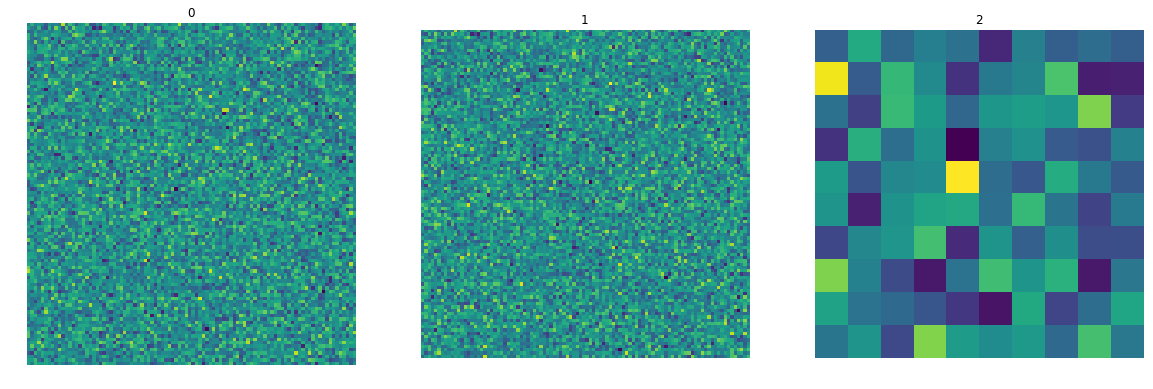

In [109]:
# visualize first layer's initial weight
show_weights(model)

In [110]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Save and load model   
See [sor](http://bit.ly/2uo4zt9), [pytorch forum](http://bit.ly/2zrvTg1)
1. Save 
```pytorch
torch.save(the_model.state_dict(), PATH)
```
2. Load
```pytorch
the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))
```

epoch 0


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([332])) that is different to the input size (torch.Size([332, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([352])) that is different to the input size (torch.Size([352, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


train loss, acc: (14.01131534576416, 0.16666666666666666)
epoch train loss: 14.27005672454834
dev loss, acc: (12.463467597961426, 0.532608695652174)
layer 0: (-3.5846806, 3.602725)
layer 1: (-3.5848842, 3.6032736)
layer 2: (-2.0596135, 2.995117)


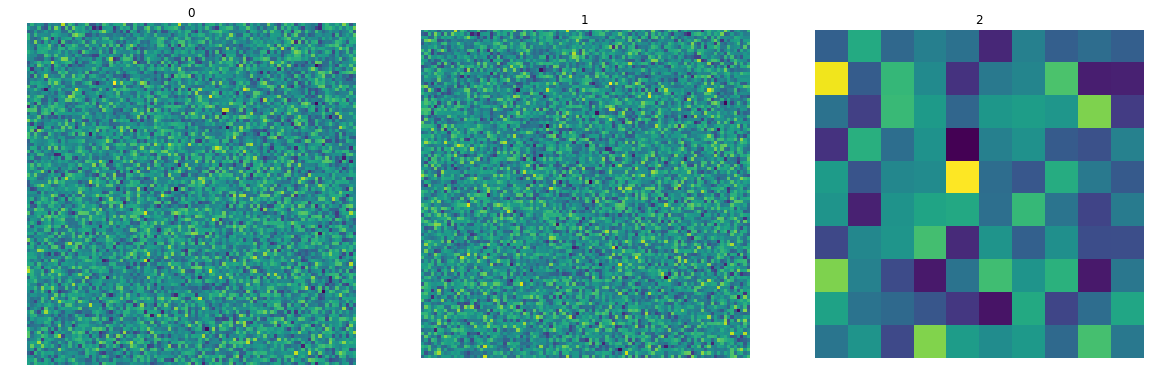

epoch 49
train loss, acc: (13.266668319702148, 0.5833333333333334)
epoch train loss: 13.208849906921387
dev loss, acc: (12.233155250549316, 0.5434782608695652)
layer 0: (-3.5818865, 3.5999804)
layer 1: (-3.5884347, 3.5982711)
layer 2: (-2.0592437, 2.9910314)


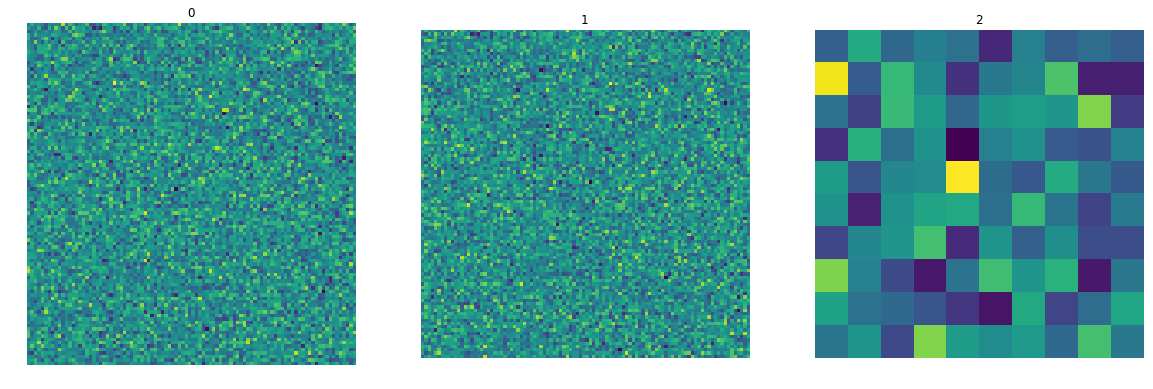

epoch 98
train loss, acc: (13.187723159790039, 0.5)
epoch train loss: 13.208417892456055
dev loss, acc: (12.229142189025879, 0.5434782608695652)
layer 0: (-3.5816996, 3.5997505)
layer 1: (-3.5886488, 3.5982711)
layer 2: (-2.059197, 2.9910524)


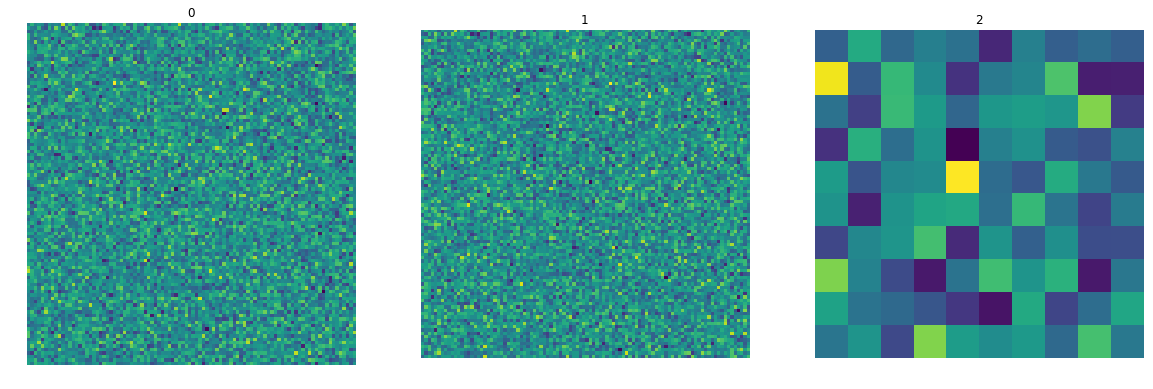

epoch 147
train loss, acc: (13.344619750976562, 0.6666666666666666)
epoch train loss: 13.208324432373047
dev loss, acc: (12.22636604309082, 0.5434782608695652)
layer 0: (-3.5816073, 3.5996249)
layer 1: (-3.5887802, 3.5982711)
layer 2: (-2.0591846, 2.9910645)


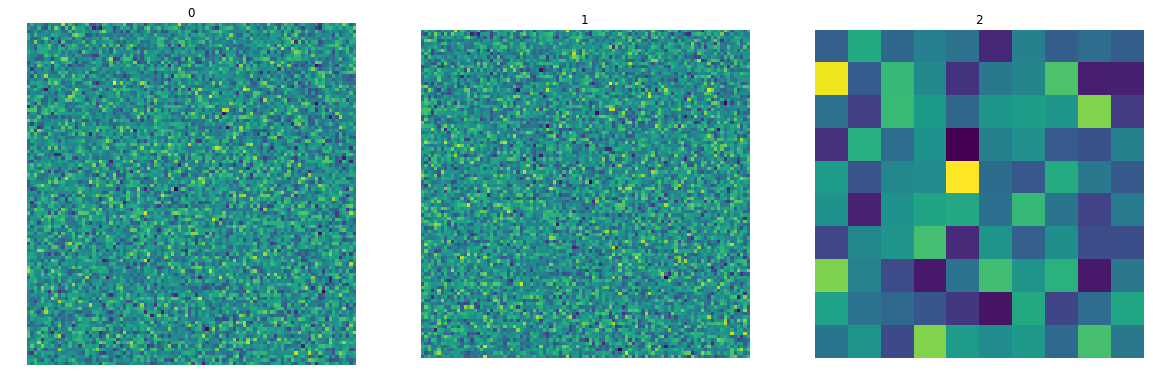

epoch 196
train loss, acc: (13.26607608795166, 0.5833333333333334)
epoch train loss: 13.20828914642334
dev loss, acc: (12.223886489868164, 0.5434782608695652)
layer 0: (-3.5815456, 3.599527)
layer 1: (-3.5888846, 3.5982711)
layer 2: (-2.0591748, 2.991072)


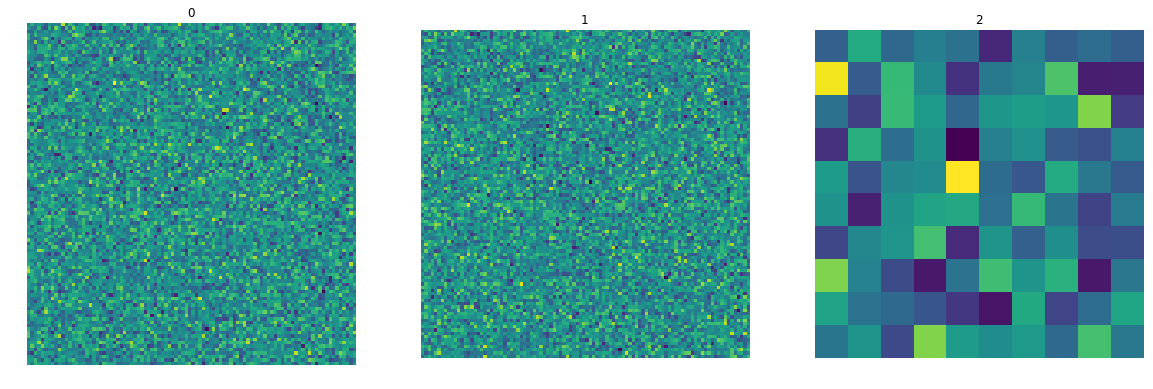

epoch 245
train loss, acc: (13.109076499938965, 0.4166666666666667)
epoch train loss: 13.208271980285645
dev loss, acc: (12.221453666687012, 0.5434782608695652)
layer 0: (-3.5814939, 3.5994487)
layer 1: (-3.5889711, 3.5982711)
layer 2: (-2.05916, 2.9910762)


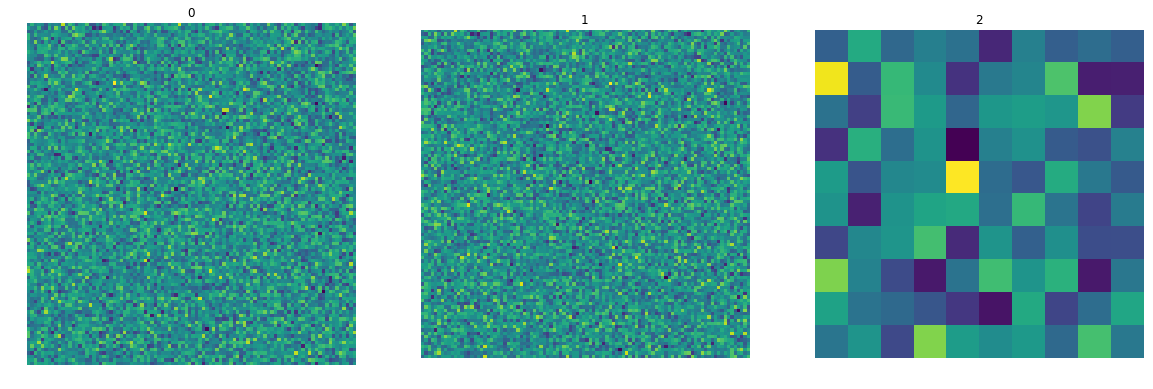

epoch 294
train loss, acc: (13.18756103515625, 0.5)
epoch train loss: 13.208259582519531
dev loss, acc: (12.219283103942871, 0.5434782608695652)
layer 0: (-3.5814476, 3.5993898)
layer 1: (-3.589048, 3.5982711)
layer 2: (-2.0591593, 2.9910786)


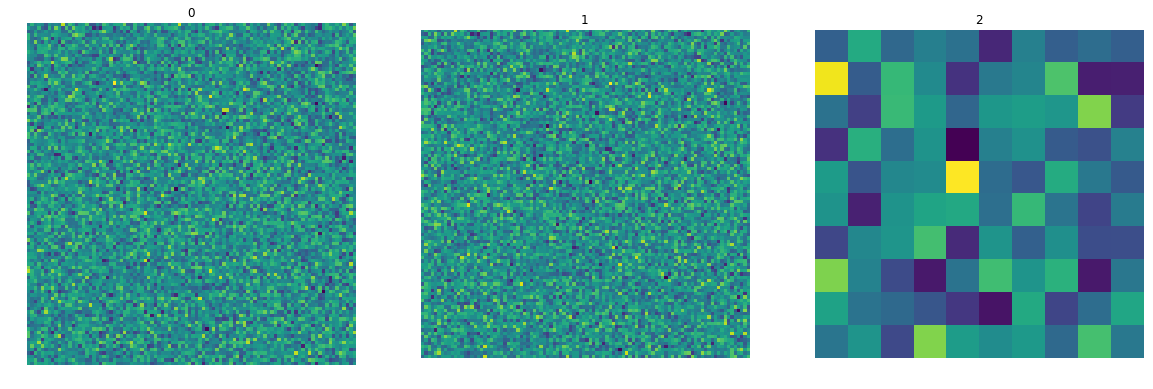

epoch 343
train loss, acc: (13.187552452087402, 0.5)
epoch train loss: 13.208251953125
dev loss, acc: (12.217159271240234, 0.5434782608695652)
layer 0: (-3.5814073, 3.5993364)
layer 1: (-3.5891066, 3.5982711)
layer 2: (-2.059158, 2.991079)


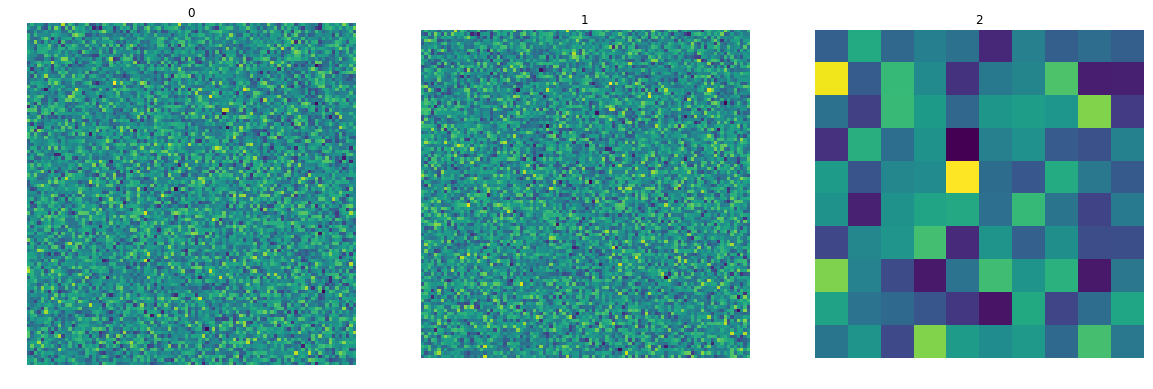

epoch 392
train loss, acc: (13.266046524047852, 0.5833333333333334)
epoch train loss: 13.20824909210205
dev loss, acc: (12.215173721313477, 0.5434782608695652)
layer 0: (-3.5813744, 3.5992901)
layer 1: (-3.5891623, 3.5982711)
layer 2: (-2.0591586, 2.99108)


epoch 441
train loss, acc: (13.187544822692871, 0.5)
epoch train loss: 13.208244323730469
dev loss, acc: (12.212881088256836, 0.5434782608695652)
layer 0: (-3.58134, 3.5992417)
layer 1: (-3.5892134, 3.5982711)
layer 2: (-2.0591533, 2.991082)


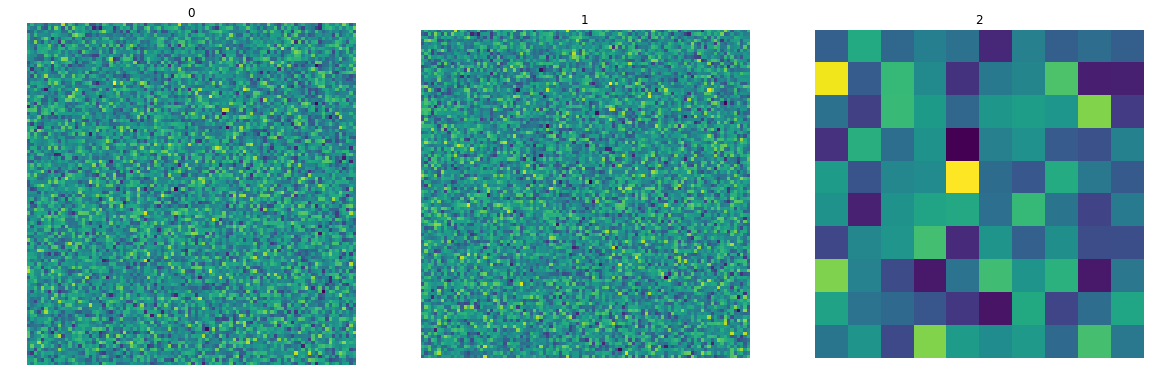

epoch 490
train loss, acc: (13.10904598236084, 0.4166666666666667)
epoch train loss: 13.208242416381836
dev loss, acc: (12.211819648742676, 0.5434782608695652)
layer 0: (-3.581306, 3.599197)
layer 1: (-3.5892582, 3.5982711)
layer 2: (-2.059161, 2.9910827)


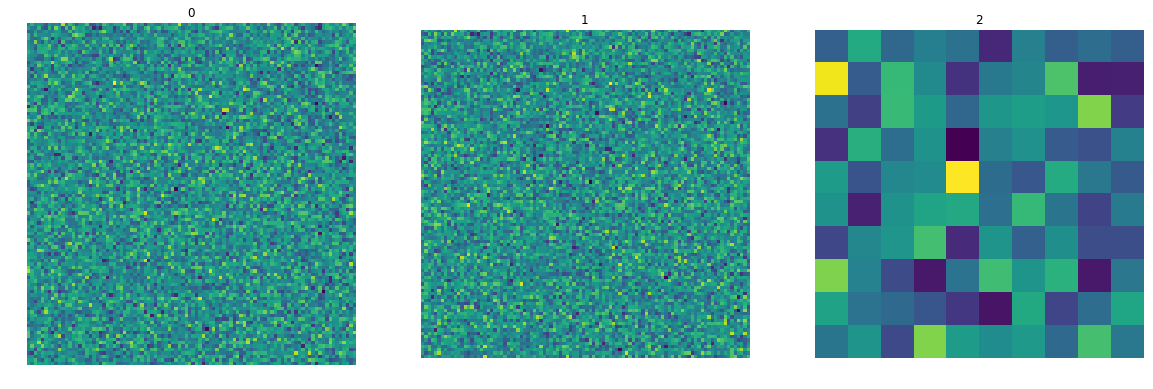

epoch 539
train loss, acc: (12.638110160827637, 0.5)
epoch train loss: 12.676922798156738
dev loss, acc: (11.624738693237305, 0.5543478260869565)
layer 0: (-3.5836616, 3.593279)
layer 1: (-3.5922132, 3.6012971)
layer 2: (-2.0618541, 2.9858992)


epoch 588
train loss, acc: (12.716582298278809, 0.5833333333333334)
epoch train loss: 12.676898956298828
dev loss, acc: (11.626935005187988, 0.5543478260869565)
layer 0: (-3.58383, 3.5932815)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0618129, 2.9858992)


epoch 637
train loss, acc: (12.873565673828125, 0.75)
epoch train loss: 12.676889419555664
dev loss, acc: (11.628521919250488, 0.5543478260869565)
layer 0: (-3.5839539, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0617683, 2.9858992)


epoch 686
train loss, acc: (12.795064926147461, 0.6666666666666666)
epoch train loss: 12.676885604858398
dev loss, acc: (11.630254745483398, 0.5543478260869565)
layer 0: (-3.5840533, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0617359, 2.9858992)


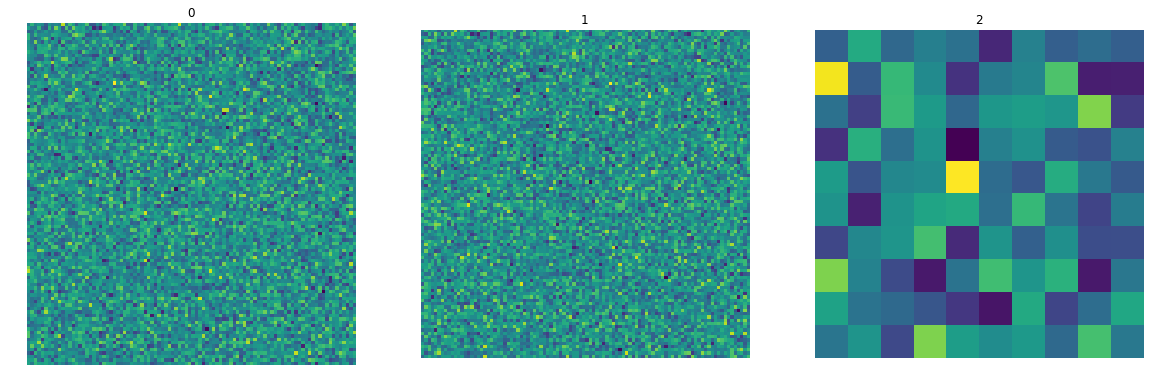

epoch 735
train loss, acc: (12.559571266174316, 0.4166666666666667)
epoch train loss: 12.67688274383545
dev loss, acc: (11.631872177124023, 0.5543478260869565)
layer 0: (-3.5841348, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0617034, 2.9858992)


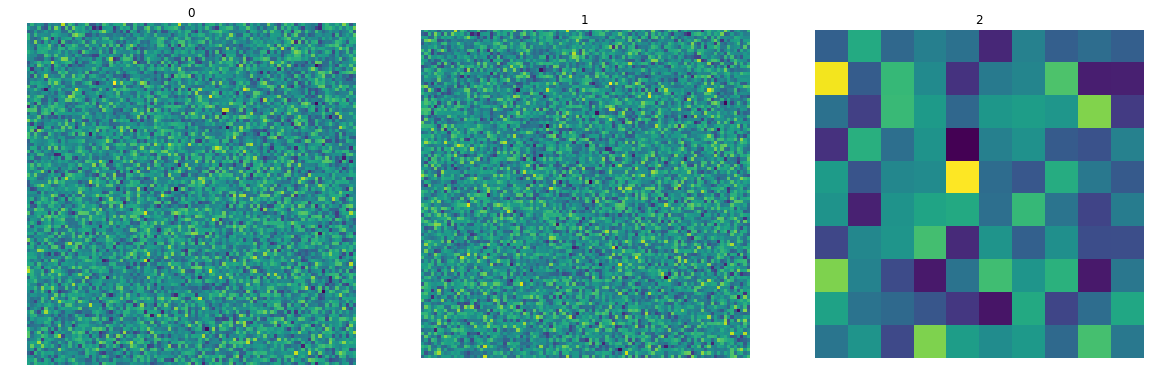

epoch 784
train loss, acc: (12.63806438446045, 0.5)
epoch train loss: 12.676878929138184
dev loss, acc: (11.632845878601074, 0.5543478260869565)
layer 0: (-3.5842044, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0616784, 2.9858992)


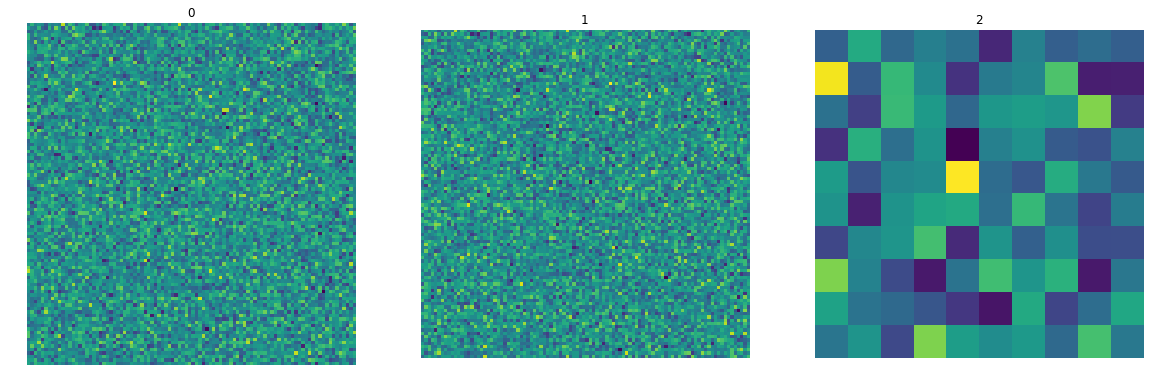

epoch 833
train loss, acc: (12.559566497802734, 0.4166666666666667)
epoch train loss: 12.67687702178955
dev loss, acc: (11.633502006530762, 0.5543478260869565)
layer 0: (-3.5842593, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0616534, 2.9858992)


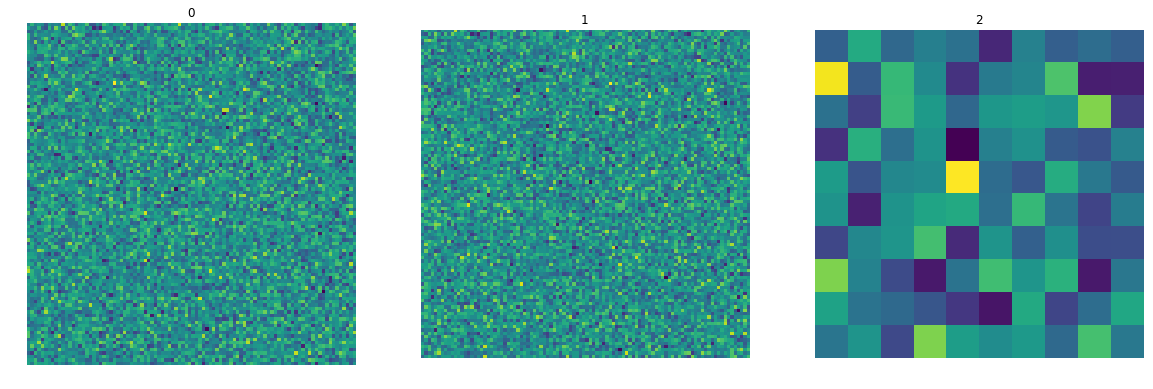

epoch 882
train loss, acc: (12.795056343078613, 0.6666666666666666)
epoch train loss: 12.67687702178955
dev loss, acc: (11.634045600891113, 0.5543478260869565)
layer 0: (-3.5843081, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0616279, 2.9858992)


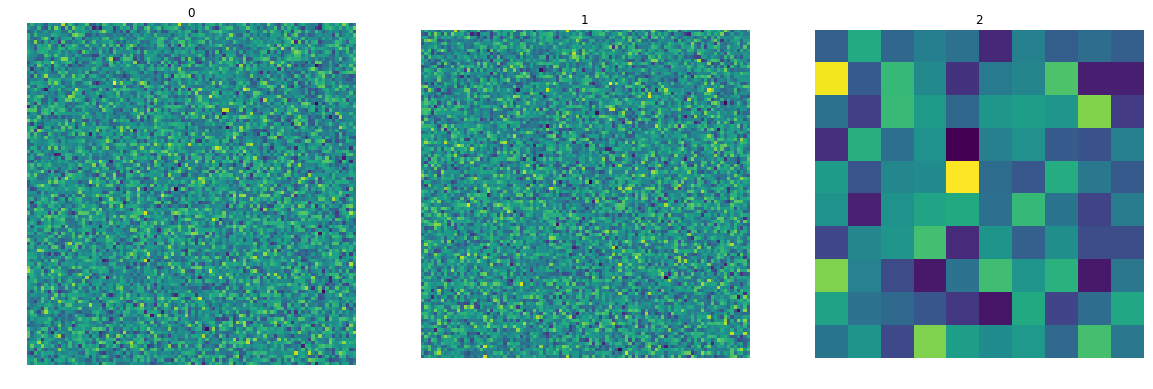

epoch 931
train loss, acc: (12.795056343078613, 0.6666666666666666)
epoch train loss: 12.67687702178955
dev loss, acc: (11.634196281433105, 0.5543478260869565)
layer 0: (-3.5843425, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0616114, 2.9858992)


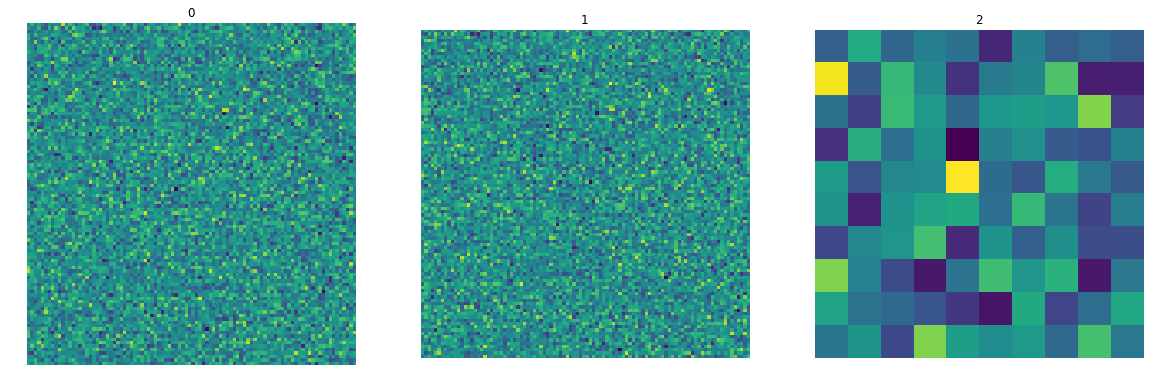

epoch 980
train loss, acc: (12.716558456420898, 0.5833333333333334)
epoch train loss: 12.676876068115234
dev loss, acc: (11.634010314941406, 0.5543478260869565)
layer 0: (-3.5843704, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0615916, 2.9858992)


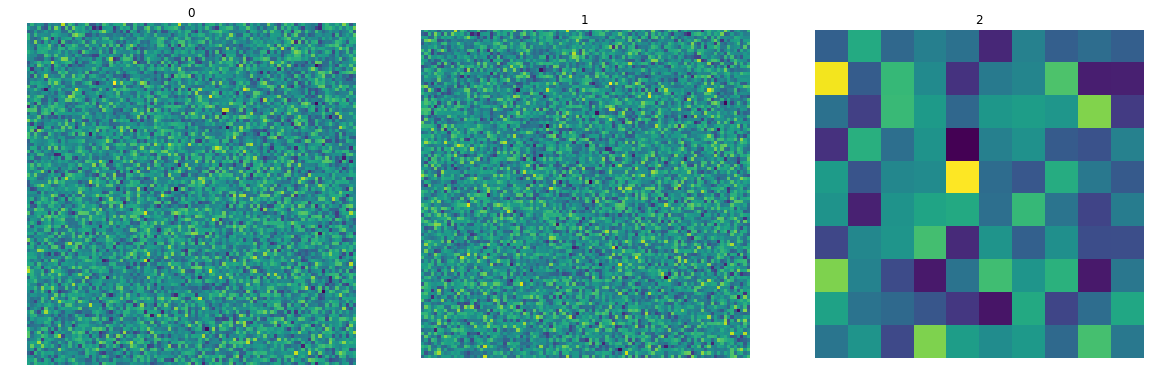

epoch 1029
train loss, acc: (12.559564590454102, 0.4166666666666667)
epoch train loss: 12.676876068115234
dev loss, acc: (11.633158683776855, 0.5543478260869565)
layer 0: (-3.5843935, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.061573, 2.9858992)


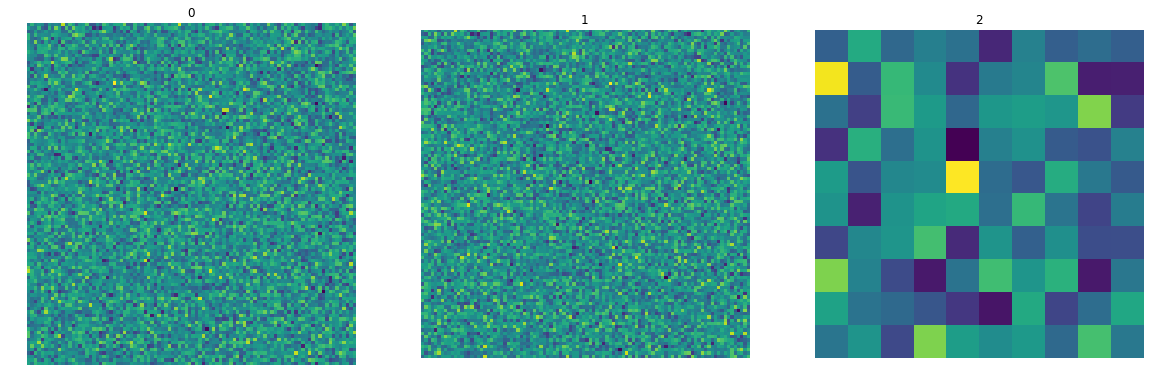

epoch 1078
train loss, acc: (12.559564590454102, 0.4166666666666667)
epoch train loss: 12.676874160766602
dev loss, acc: (11.632150650024414, 0.5543478260869565)
layer 0: (-3.5844178, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0615578, 2.9858992)


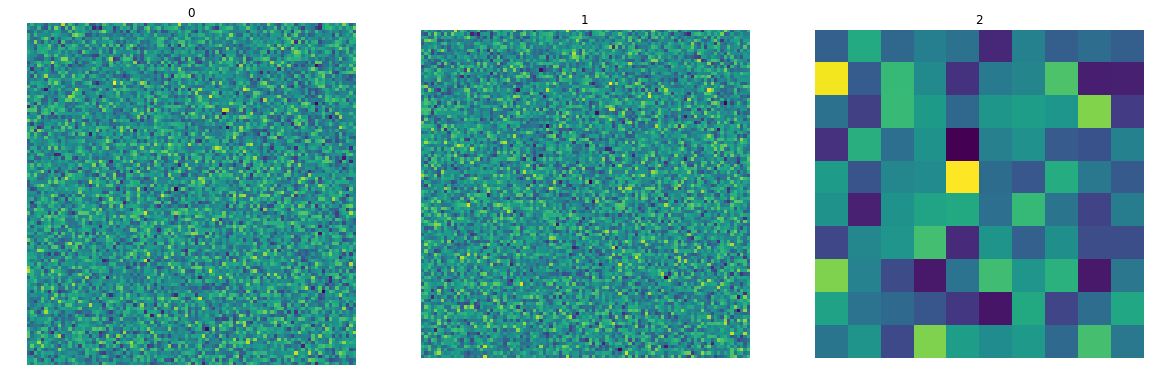

epoch 1127
train loss, acc: (12.481066703796387, 0.3333333333333333)
epoch train loss: 12.676874160766602
dev loss, acc: (11.63097095489502, 0.5543478260869565)
layer 0: (-3.5844355, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0615444, 2.9858992)


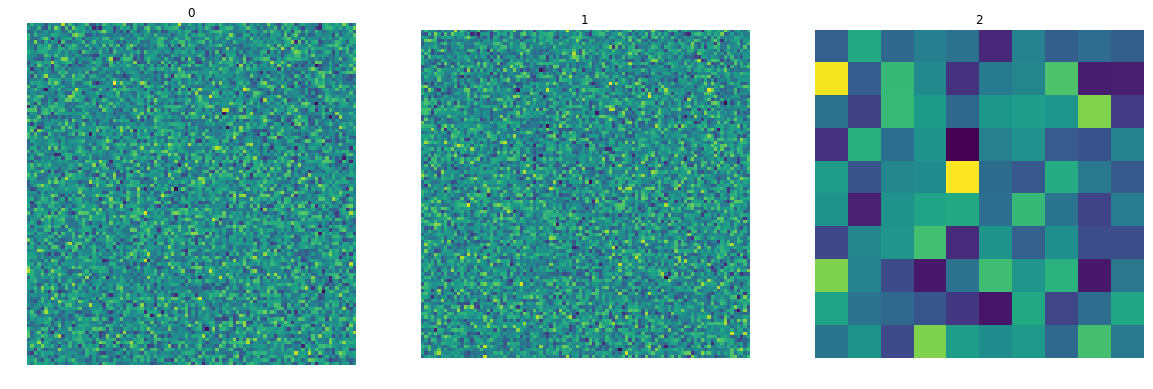

epoch 1176
train loss, acc: (12.638060569763184, 0.5)
epoch train loss: 12.676874160766602
dev loss, acc: (11.629865646362305, 0.5543478260869565)
layer 0: (-3.5844467, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0615299, 2.9858992)


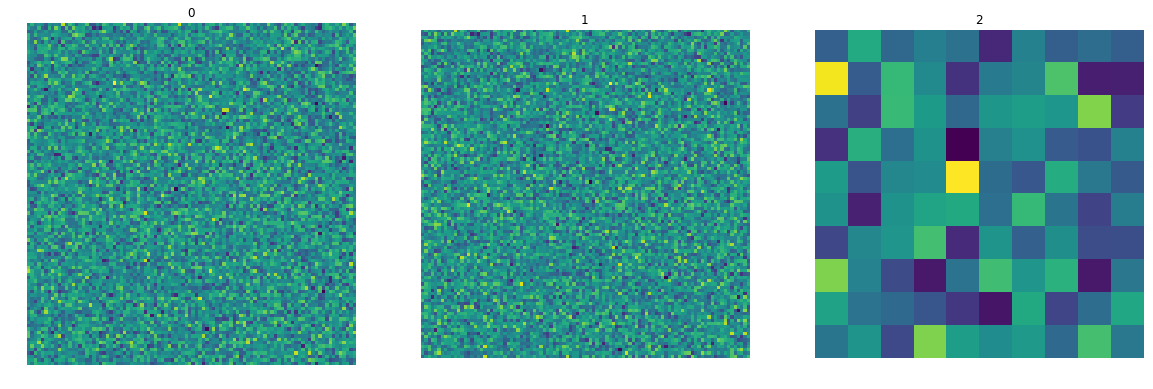

epoch 1225
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.62841796875, 0.5543478260869565)
layer 0: (-3.58446, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0615077, 2.9858992)


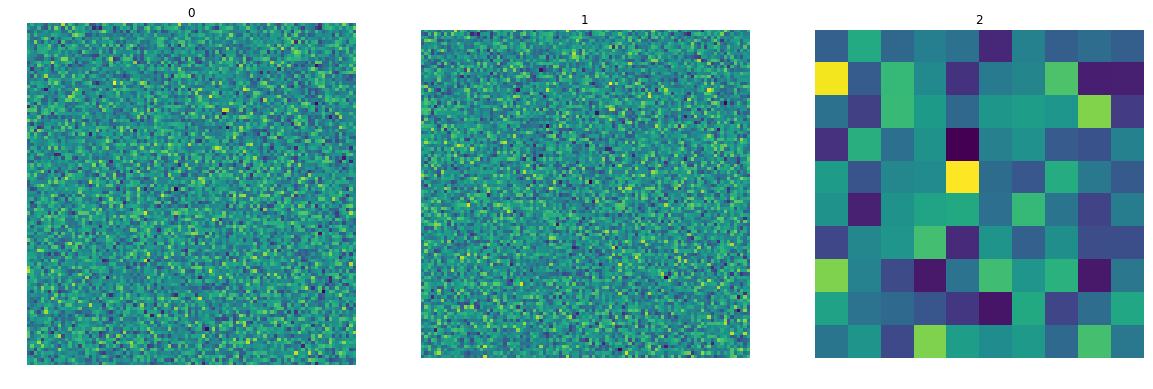

epoch 1274
train loss, acc: (12.795053482055664, 0.6666666666666666)
epoch train loss: 12.676874160766602
dev loss, acc: (11.62688159942627, 0.5543478260869565)
layer 0: (-3.584471, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.061486, 2.9858992)


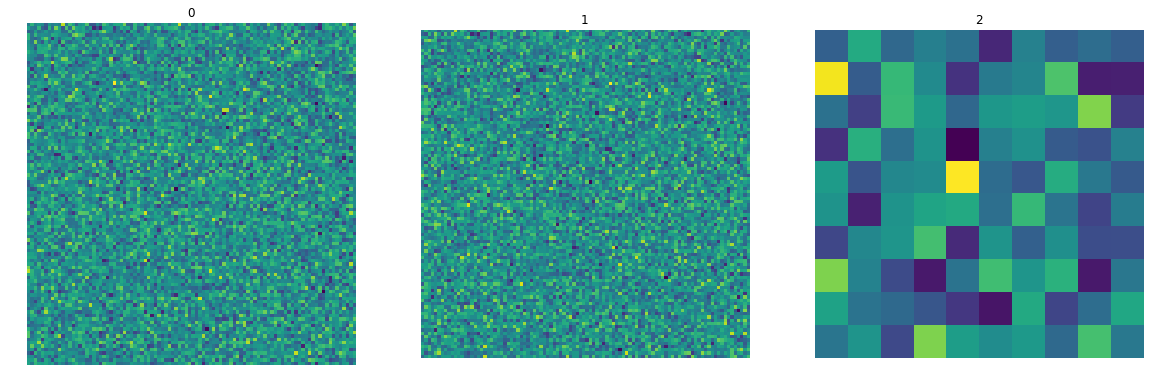

epoch 1323
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.62570858001709, 0.5543478260869565)
layer 0: (-3.5844734, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.061467, 2.9858992)


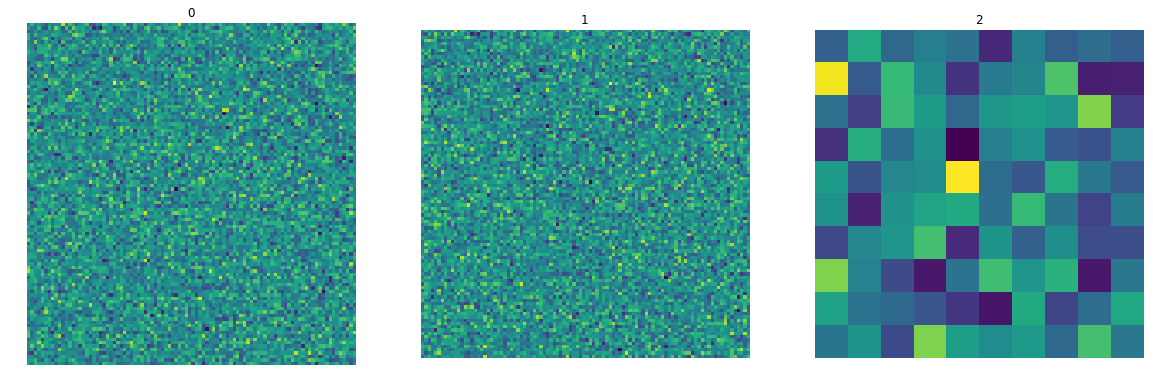

epoch 1372
train loss, acc: (12.481066703796387, 0.3333333333333333)
epoch train loss: 12.676874160766602
dev loss, acc: (11.624212265014648, 0.5543478260869565)
layer 0: (-3.5844798, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0614476, 2.9858992)


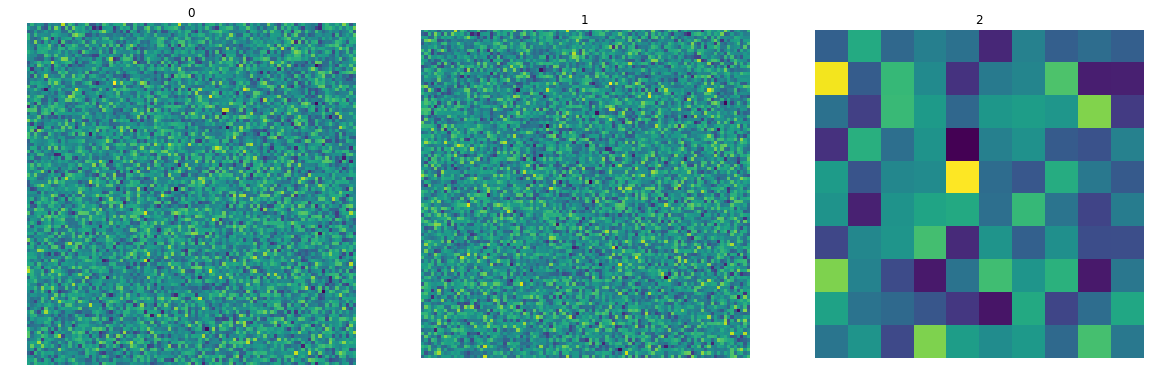

epoch 1421
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.622716903686523, 0.5543478260869565)
layer 0: (-3.5844824, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0614262, 2.9858992)


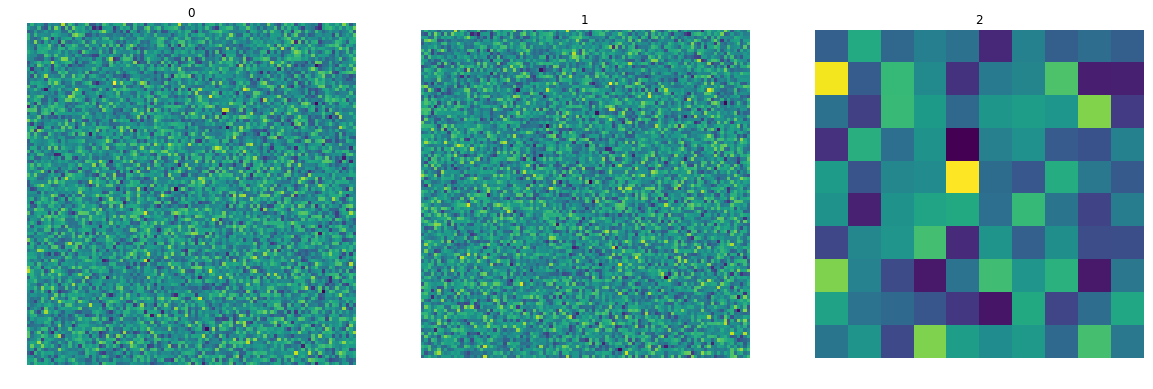

epoch 1470
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.621255874633789, 0.5543478260869565)
layer 0: (-3.5844867, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0614023, 2.9858992)


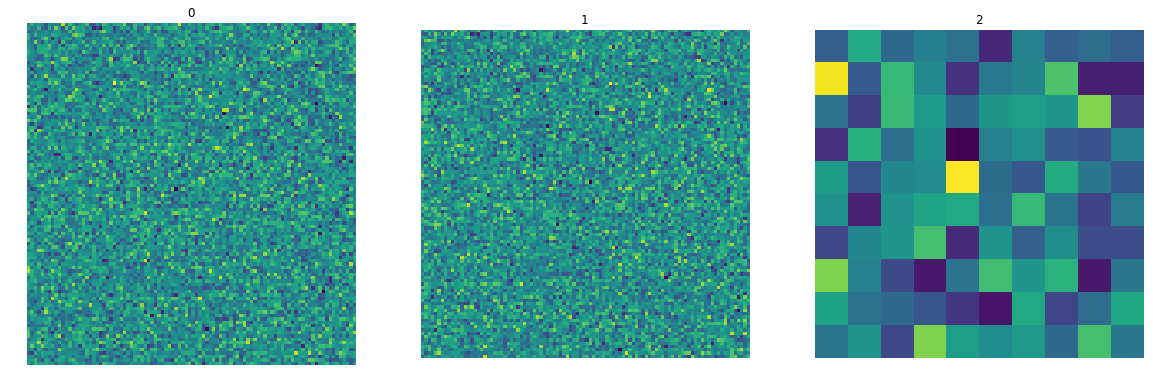

epoch 1519
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.61949634552002, 0.5543478260869565)
layer 0: (-3.5844898, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0613794, 2.9858992)


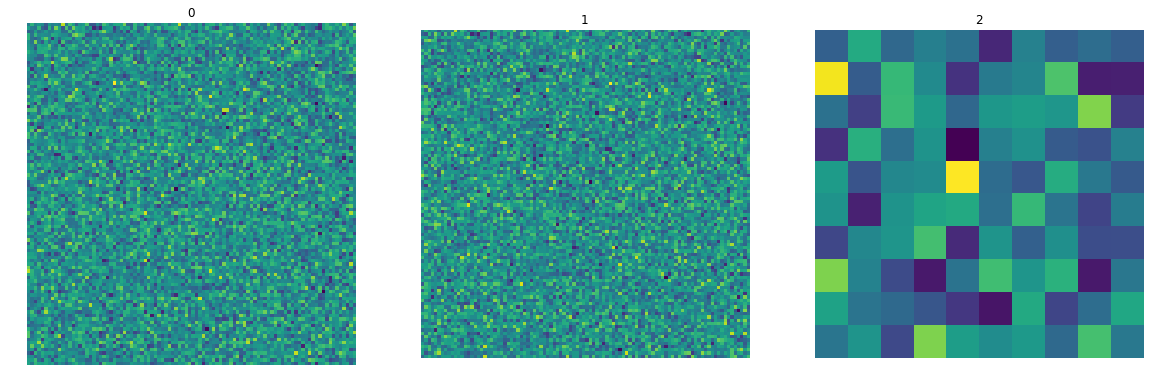

epoch 1568
train loss, acc: (12.638060569763184, 0.5)
epoch train loss: 12.676874160766602
dev loss, acc: (11.617815971374512, 0.5543478260869565)
layer 0: (-3.5844855, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0613606, 2.9858992)


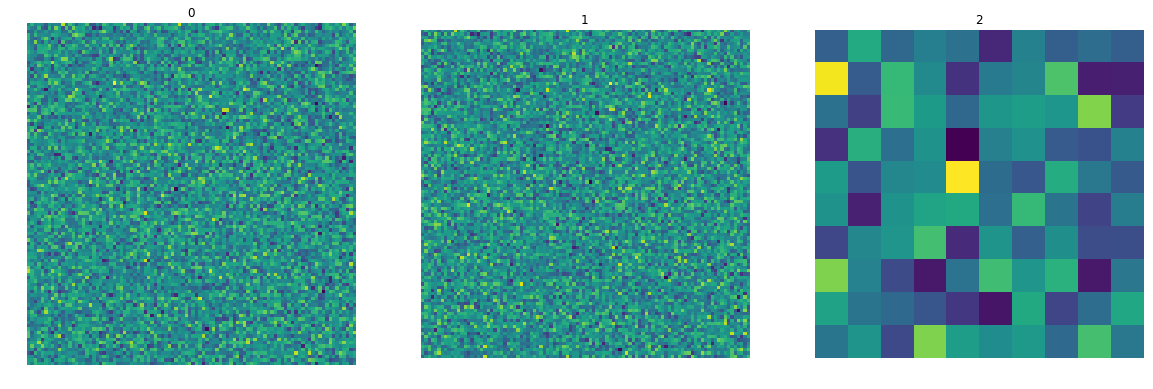

epoch 1617
train loss, acc: (12.638060569763184, 0.5)
epoch train loss: 12.676874160766602
dev loss, acc: (11.616106033325195, 0.5543478260869565)
layer 0: (-3.5844824, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0613363, 2.9858992)


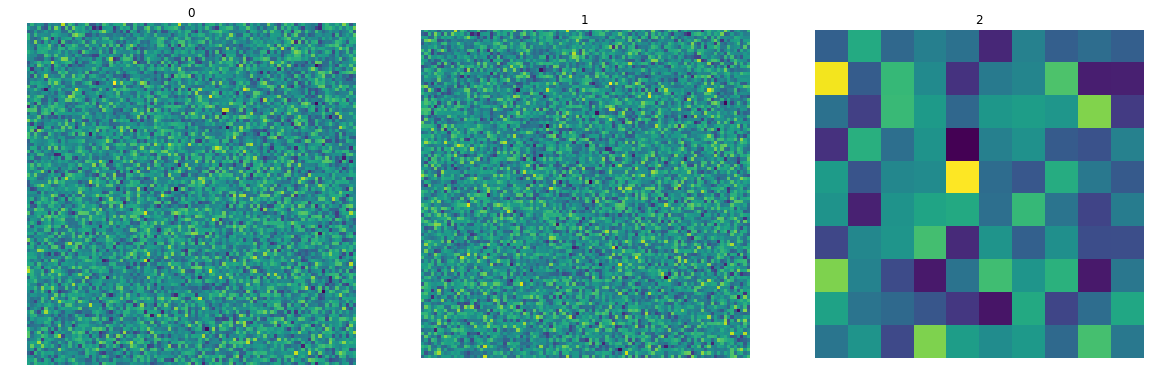

epoch 1666
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.61373519897461, 0.5543478260869565)
layer 0: (-3.5844774, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0613172, 2.9858992)


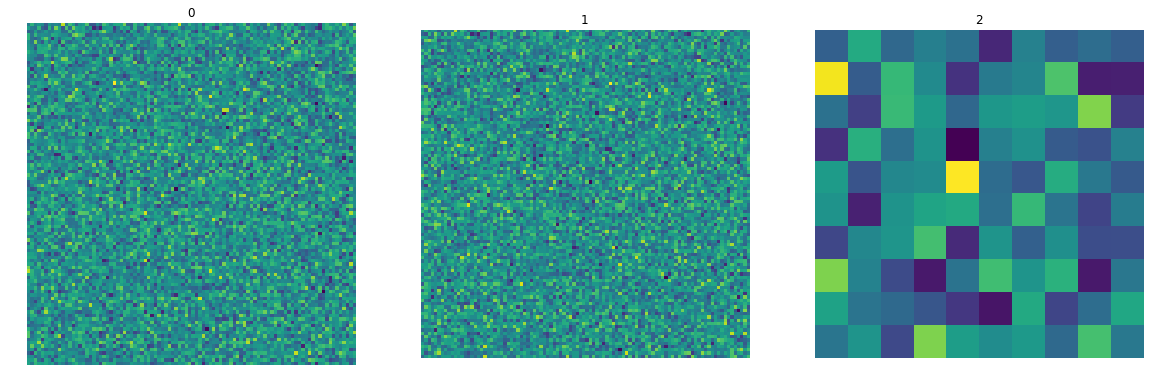

epoch 1715
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.611305236816406, 0.5543478260869565)
layer 0: (-3.5844624, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0612888, 2.9858992)


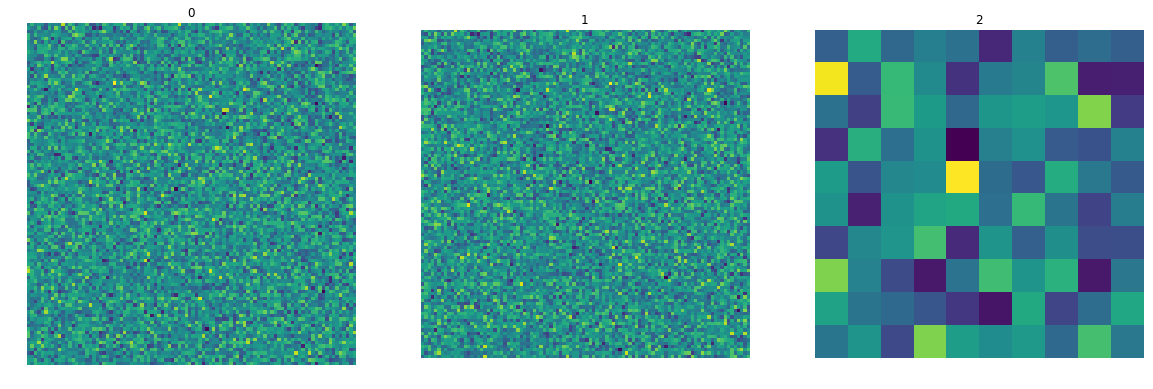

epoch 1764
train loss, acc: (12.638060569763184, 0.5)
epoch train loss: 12.676874160766602
dev loss, acc: (11.608388900756836, 0.5543478260869565)
layer 0: (-3.584436, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0612662, 2.9858992)


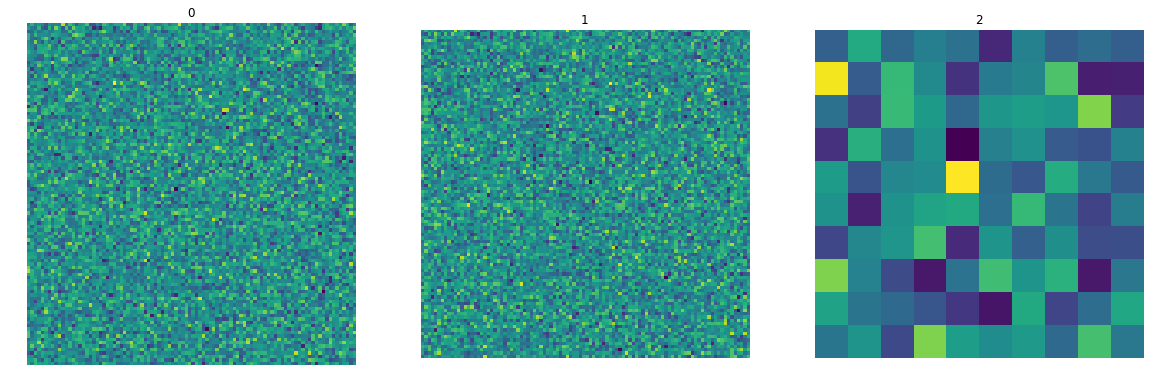

epoch 1813
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.605013847351074, 0.5543478260869565)
layer 0: (-3.584388, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.061242, 2.9858992)


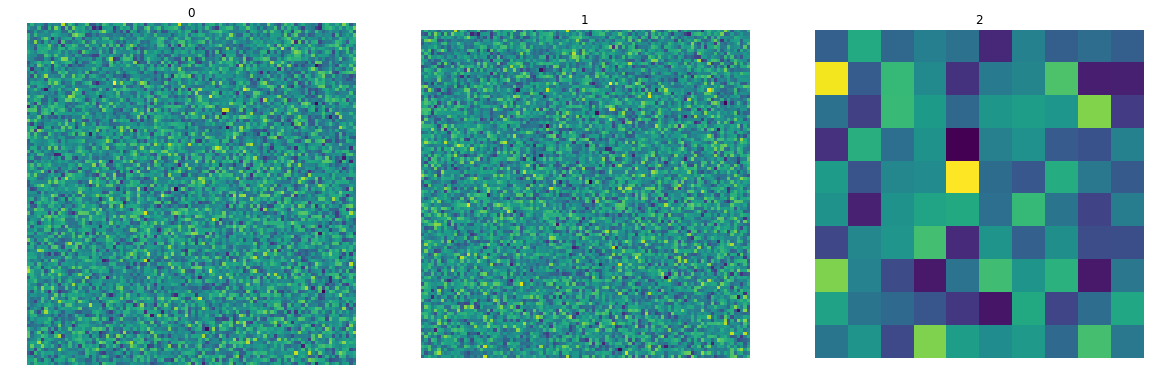

epoch 1862
train loss, acc: (12.481066703796387, 0.3333333333333333)
epoch train loss: 12.676874160766602
dev loss, acc: (11.601583480834961, 0.5543478260869565)
layer 0: (-3.584334, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0612142, 2.9858992)


epoch 1911
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.598416328430176, 0.5543478260869565)
layer 0: (-3.5842934, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.061195, 2.9858992)


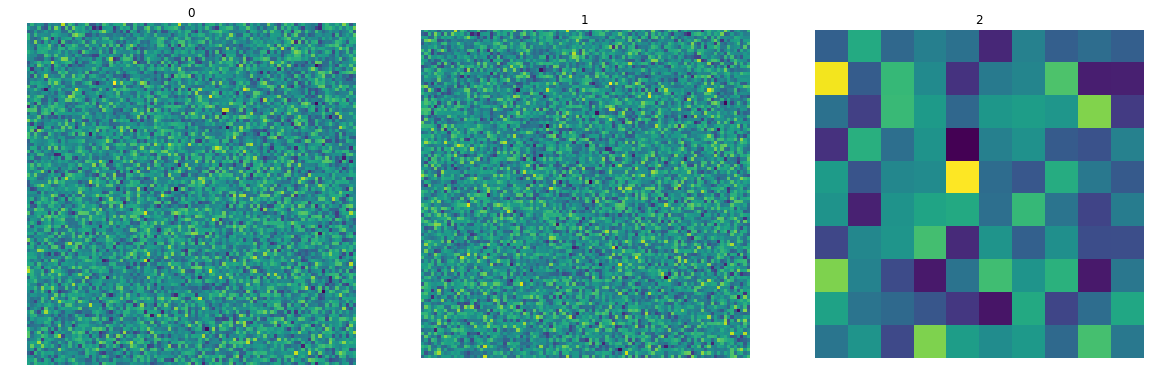

epoch 1960
train loss, acc: (12.402569770812988, 0.25)
epoch train loss: 12.676874160766602
dev loss, acc: (11.594468116760254, 0.5543478260869565)
layer 0: (-3.5842042, 3.5932817)
layer 1: (-3.592212, 3.6012971)
layer 2: (-2.0611672, 2.9858992)


epoch 2009
train loss, acc: (12.481066703796387, 0.3333333333333333)
epoch train loss: 12.676874160766602
dev loss, acc: (11.589556694030762, 0.5543478260869565)
layer 0: (-3.5840697, 3.5932817)
layer 1: (-3.5922112, 3.6012971)
layer 2: (-2.0611513, 2.9858992)


epoch 2058
train loss, acc: (12.638060569763184, 0.5)
epoch train loss: 12.676874160766602
dev loss, acc: (11.584463119506836, 0.5543478260869565)
layer 0: (-3.5839548, 3.5932817)
layer 1: (-3.5922112, 3.6012971)
layer 2: (-2.061145, 2.9858992)


epoch 2107
train loss, acc: (12.559563636779785, 0.4166666666666667)
epoch train loss: 12.676874160766602
dev loss, acc: (11.577252388000488, 0.5543478260869565)
layer 0: (-3.5838783, 3.5932817)
layer 1: (-3.5922112, 3.6012971)
layer 2: (-2.0611353, 2.9858992)


epoch 2156
train loss, acc: (12.559563636779785, 0.4166666666666667)
epoch train loss: 12.676874160766602
dev loss, acc: (11.57007122039795, 0.5543478260869565)
layer 0: (-3.5837743, 3.5932817)
layer 1: (-3.5922103, 3.6012971)
layer 2: (-2.0611255, 2.9859004)


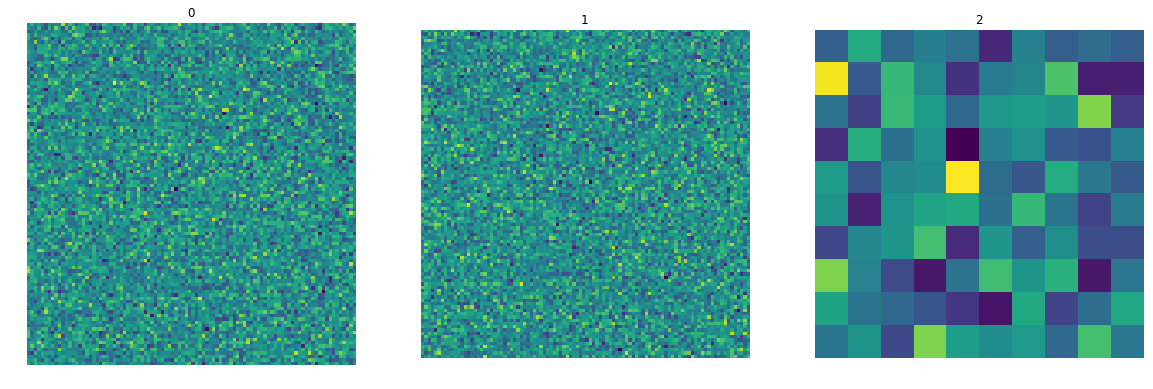

epoch 2205
train loss, acc: (12.873550415039062, 0.75)
epoch train loss: 12.676874160766602
dev loss, acc: (11.56639575958252, 0.5543478260869565)
layer 0: (-3.5836377, 3.5932827)
layer 1: (-3.5922043, 3.6012971)
layer 2: (-2.0611205, 2.9859035)


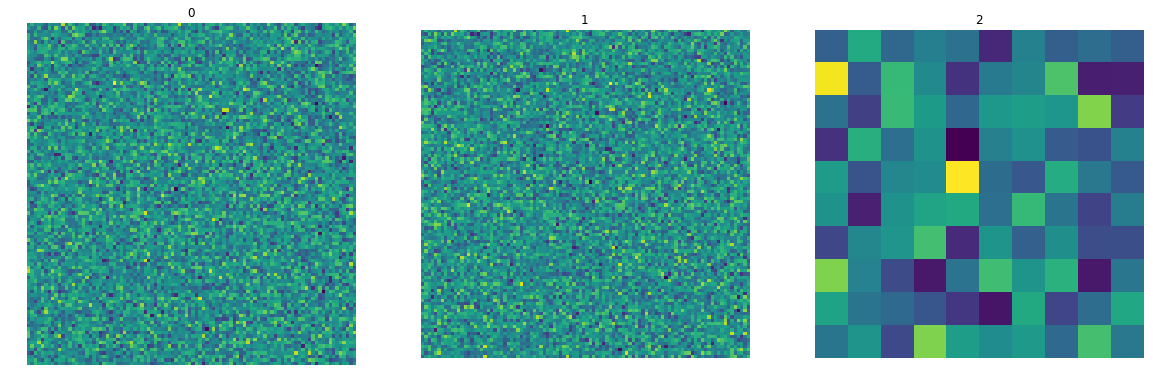

epoch 2254
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.562838554382324, 0.5543478260869565)
layer 0: (-3.583495, 3.5932834)
layer 1: (-3.5921977, 3.6012971)
layer 2: (-2.0611222, 2.9859083)


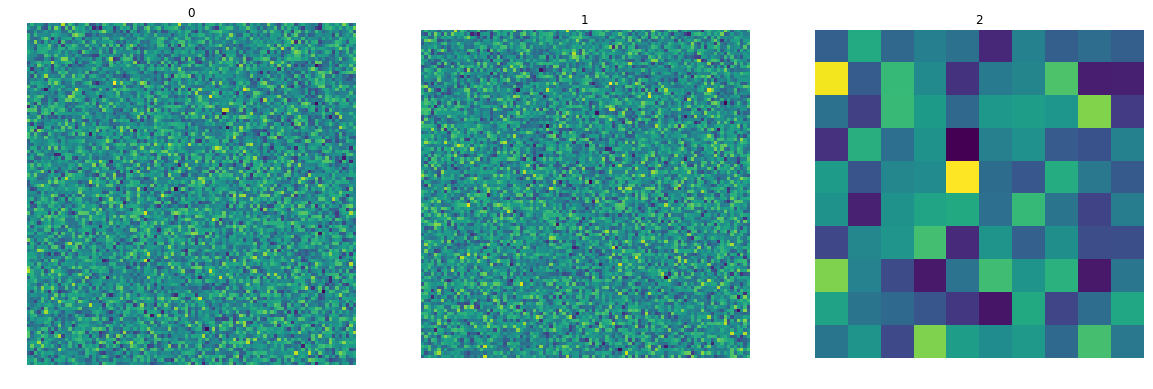

epoch 2303
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.559786796569824, 0.5543478260869565)
layer 0: (-3.5833588, 3.5932891)
layer 1: (-3.5921881, 3.6012971)
layer 2: (-2.0611181, 2.9859142)


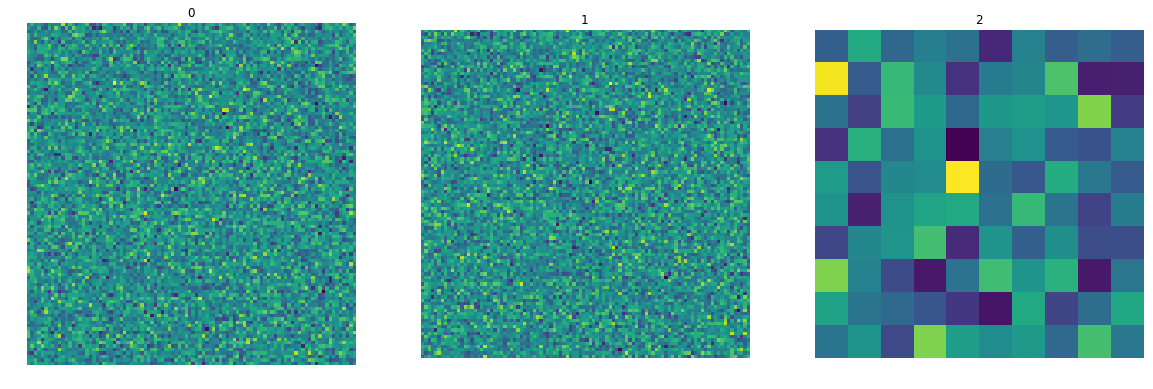

epoch 2352
train loss, acc: (12.481066703796387, 0.3333333333333333)
epoch train loss: 12.676874160766602
dev loss, acc: (11.556172370910645, 0.5543478260869565)
layer 0: (-3.5832057, 3.5932944)
layer 1: (-3.592178, 3.6012971)
layer 2: (-2.061117, 2.9859207)


epoch 2401
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.553027153015137, 0.5543478260869565)
layer 0: (-3.5830638, 3.5933025)
layer 1: (-3.5921674, 3.6012971)
layer 2: (-2.0611181, 2.9859338)


epoch 2450
train loss, acc: (12.795053482055664, 0.6666666666666666)
epoch train loss: 12.676874160766602
dev loss, acc: (11.549306869506836, 0.5543478260869565)
layer 0: (-3.5828946, 3.593309)
layer 1: (-3.5921557, 3.6012971)
layer 2: (-2.061125, 2.9859462)


epoch 2499
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.5457763671875, 0.5543478260869565)
layer 0: (-3.5827744, 3.5933158)
layer 1: (-3.5921433, 3.6012971)
layer 2: (-2.0611184, 2.9859614)


epoch 2548
train loss, acc: (12.952047348022461, 0.8333333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.543731689453125, 0.5543478260869565)
layer 0: (-3.582624, 3.5933213)
layer 1: (-3.5921352, 3.6012971)
layer 2: (-2.0611095, 2.9859798)


epoch 2597
train loss, acc: (13.03054428100586, 0.9166666666666666)
epoch train loss: 12.676874160766602
dev loss, acc: (11.541934967041016, 0.5543478260869565)
layer 0: (-3.582485, 3.5933273)
layer 1: (-3.5921254, 3.6012971)
layer 2: (-2.061091, 2.9860055)


epoch 2646
train loss, acc: (12.638060569763184, 0.5)
epoch train loss: 12.676874160766602
dev loss, acc: (11.539557456970215, 0.5543478260869565)
layer 0: (-3.5823882, 3.5933008)
layer 1: (-3.5921135, 3.6012971)
layer 2: (-2.0610986, 2.9860227)


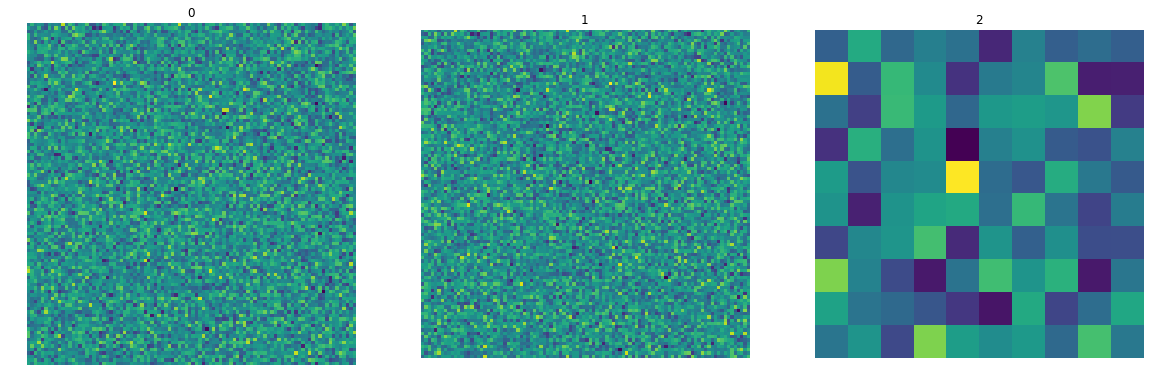

epoch 2695
train loss, acc: (12.873550415039062, 0.75)
epoch train loss: 12.676874160766602
dev loss, acc: (11.537640571594238, 0.5652173913043478)
layer 0: (-3.5822406, 3.593309)
layer 1: (-3.5920992, 3.6012971)
layer 2: (-2.0610952, 2.9860406)


epoch 2744
train loss, acc: (12.795053482055664, 0.6666666666666666)
epoch train loss: 12.676874160766602
dev loss, acc: (11.536456108093262, 0.5652173913043478)
layer 0: (-3.5821323, 3.5933237)
layer 1: (-3.5920794, 3.6012971)
layer 2: (-2.0610907, 2.9860806)


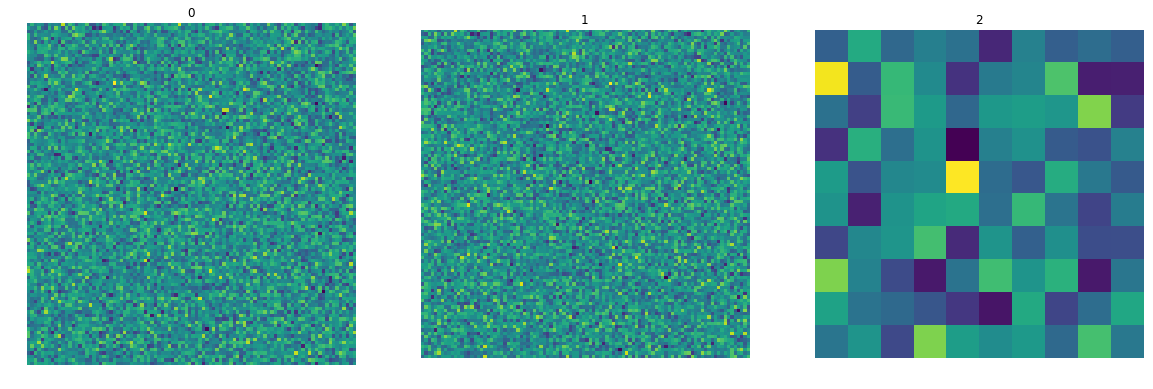

epoch 2793
train loss, acc: (12.481066703796387, 0.3333333333333333)
epoch train loss: 12.676874160766602
dev loss, acc: (11.539641380310059, 0.5652173913043478)
layer 0: (-3.5820706, 3.5932488)
layer 1: (-3.5920794, 3.6012971)
layer 2: (-2.0610392, 2.9861076)


epoch 2842
train loss, acc: (12.716556549072266, 0.5833333333333334)
epoch train loss: 12.676874160766602
dev loss, acc: (11.538089752197266, 0.5652173913043478)
layer 0: (-3.5819867, 3.593268)
layer 1: (-3.5920546, 3.6012971)
layer 2: (-2.0610702, 2.9861147)


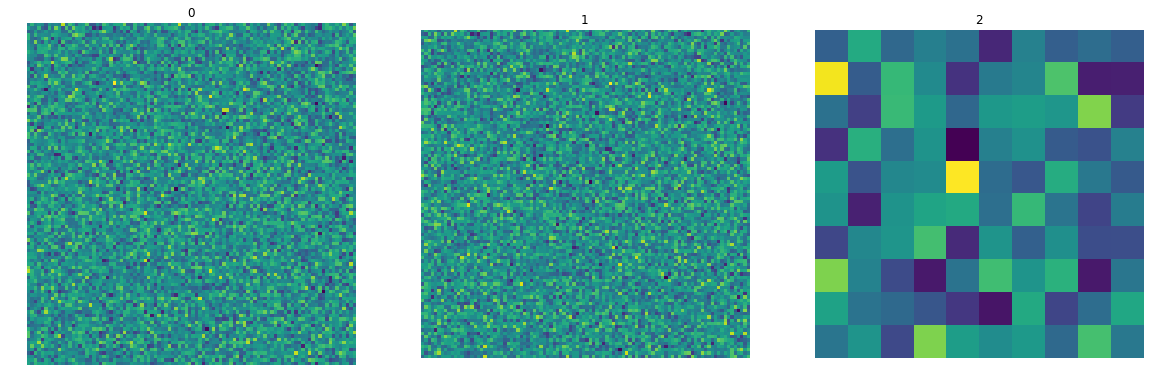

epoch 2891
train loss, acc: (12.638060569763184, 0.5)
epoch train loss: 12.676874160766602
dev loss, acc: (11.533915519714355, 0.5652173913043478)
layer 0: (-3.5818393, 3.5932677)
layer 1: (-3.5920546, 3.6012971)
layer 2: (-2.0610101, 2.9861798)


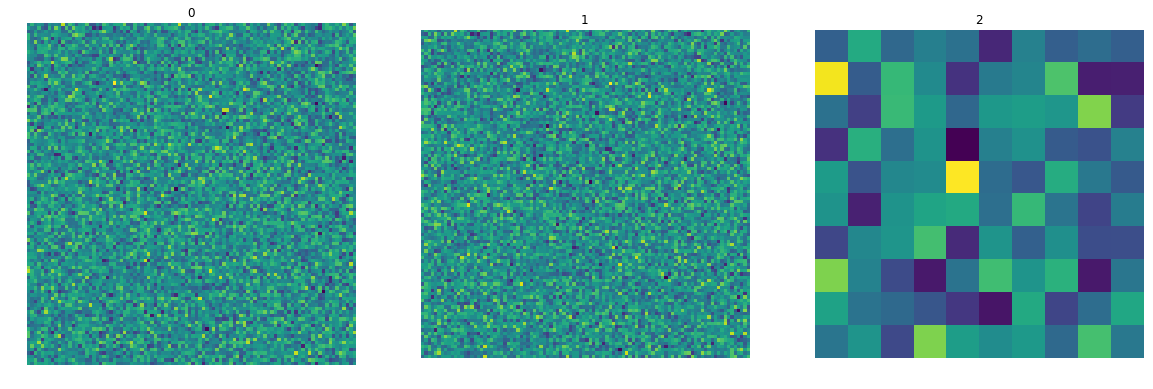

epoch 2940
train loss, acc: (12.873550415039062, 0.75)
epoch train loss: 12.676874160766602
dev loss, acc: (11.534041404724121, 0.5543478260869565)
layer 0: (-3.5817568, 3.5932677)
layer 1: (-3.5920546, 3.6012971)
layer 2: (-2.0610447, 2.9861836)


epoch 2989
train loss, acc: (12.638060569763184, 0.5)
epoch train loss: 12.676874160766602
dev loss, acc: (11.533753395080566, 0.5434782608695652)
layer 0: (-3.5816543, 3.5933433)
layer 1: (-3.5919704, 3.6012971)
layer 2: (-2.061076, 2.986193)


In [111]:
# Train
debug = False
verbose = True

# loss and acc from each batch (ie. per cycle)
batch_ls = []
train_ls = []
batch_accs = []
batch_hit_accs = []

# loss and acc from each epoch (ie. per epoch)
dev_ls = []
dev_accs = []
epoch_dev_hit_accs = []

epoch_train_ls = []

for epoch in range(nEpoch):
    if (epoch%49 == 0): print("="*30); print(f'epoch {epoch}')

    for i, (x_batch, y_batch, i_batch) in enumerate(train_loader):
        if debug:
            print(x_batch.size())
            print(y_batch.size())
            print(i_batch.size())
            pdb.set_trace()

        #forward
        ypred_batch = model(x_batch).view(y_batch.size())
        
        #loss
        l = criterion(ypred_batch, y_batch)
        batch_ls.append(l.item())
        
        #zero-out grads
        optimizer.zero_grad()

        #backward pass
        l.backward()

        #update parameters
        optimizer.step()
        
        if debug:
            print(ypred_batch.size(), ypred_batch.dtype)
            print(y_batch.size(), y_batch.dtype)
            print(i_batch)
            pdb.set_trace()
            
        # Compute training loss and accuracy
        train_l = get_train_loss(model, criterion, train_dataset, i_batch)
        train_ls.append(train_l)
        
        # make a decision at 0.5
        # boolean tensor is uint8 type. Cast it to tensor.float32
        decision_batch = (ypred_batch > 0.5).view(y_batch.size()).type(y_batch.dtype)
        isCorrect_batch = (decision_batch==y_batch).numpy()
        batch_acc = sum(isCorrect_batch)/len(isCorrect_batch)
        batch_accs.append(batch_acc)

        # 0->0 accuracy, 1->1 accuracy
        batch_size = len(y_batch)
        hit_accs = []
        for label in y_batch.unique():
            hit_count = [1 for i in range(batch_size) if decision_batch[i]==label and y_batch[i]==label]
#             pdb.set_trace()
            hit_acc = sum(hit_count) / sum(y_batch==label).item()
            hit_accs.append(hit_acc)
        # collect hit_accs from each cycle
        batch_hit_accs.append(hit_accs)
        
    # Dev accuracy
    epoch_train_l, _, _ = get_loss_on_entire_dataset(model, 
                                               criterion, 
                                               loader=heavy_train_loader)
    
    dev_l, dev_acc, dev_hit_accs = get_loss_on_entire_dataset(model, 
                                                              criterion, 
                                                              loader=dev_loader)
    dev_ls.append(dev_l)
    dev_accs.append(dev_acc)
    epoch_dev_hit_accs.append(dev_hit_accs)
    
    epoch_train_ls.append(epoch_train_l)
    
    if (verbose and epoch%49 == 0):
        print(f"train loss, acc: {train_ls[-1], batch_accs[-1]}")
        print(f"epoch train loss: {epoch_train_ls[-1]}")
        print(f"dev loss, acc: {dev_ls[-1], dev_accs[-1]}")
        
        # visualize weights
#         f,axes = plt.subplots(1,3, figsize=(20,10))
#         axes = axes.flatten()
        for i,m in enumerate(model.children()):
            if isinstance(m, nn.Linear):
                w = m.weight.data.numpy()
                if w.shape[0] == 1 or w.shape[1] == 1:
                    w = w.reshape((-1,10))
                    
                print (f'layer {i}: {w.min(), w.max()}')
#                 axes[i].set_title(str(i))
#                 axes[i].axis('off')
#                 axes[i].imshow(w)
#         plt.show()
   
    
    # todo: accuracy on all training dataset
# save current trained model
from time import gmtime, strftime

outname = strftime("%Y_%m_%d_%H_%M", gmtime())
torch.save(model.state_dict(), ROOT/f'TrainedModel/nn_{outname}.pth.tar' )

Train batch losses: (5.076783180236816, 4.993556499481201)
Train acc: (0.875, 0.84375)
Dev loss: (5.133751392364502, 5.140986442565918)
Dev acc: (0.782608695652174, 0.782608695652174)


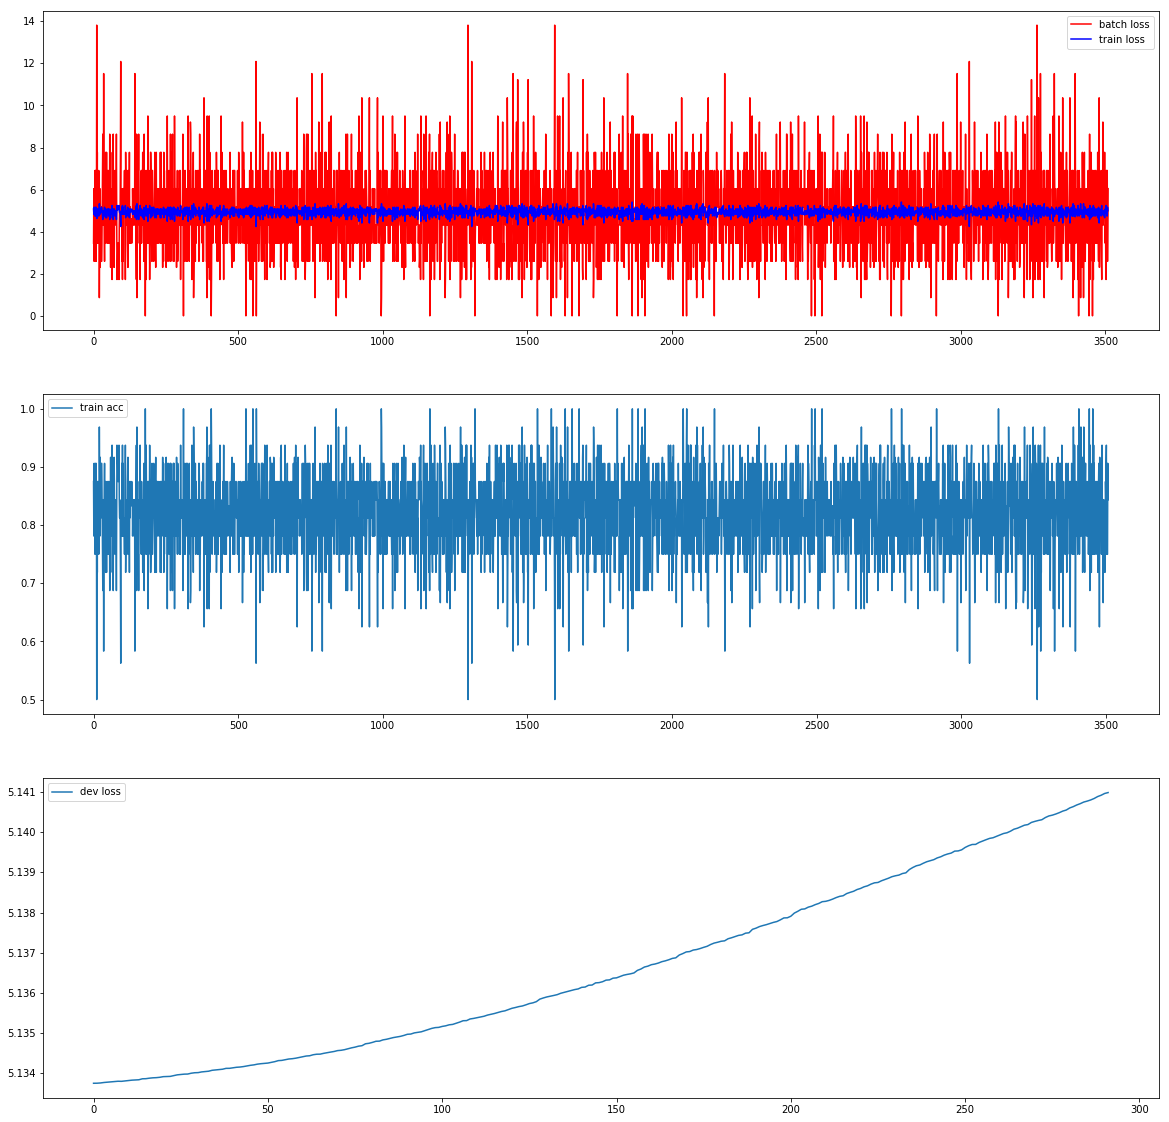

In [88]:
f,axes = plt.subplots(3,1,figsize=(20,20))
axes = axes.flatten()
axes[0].plot(batch_ls, 'r', label='batch loss')
axes[0].plot(train_ls, 'b', label='train loss')
axes[1].plot(batch_accs, label='train acc')

axes[2].plot(dev_ls, label='dev loss') #Devset error

for ax in axes:
    ax.legend(loc='best')
    
print(f"Train batch losses: {train_ls[0], train_ls[-1]}")
print(f"Train acc: {batch_accs[0], batch_accs[-1]}")

print(f"Dev loss: {dev_ls[0], dev_ls[-1]}")
print(f"Dev acc: {dev_accs[0], dev_accs[-1]}")

Devset error

In [ ]:
#Test loop
# test loss
test_ls = []
test_isCorrects = []
with torch.no_grad():
    for i, (xtest, ytest, _) in enumerate(test_loader):
        n_test = len(test_loader.dataset)
        assert (n_test == test_loader.batch_size)
        
        ypred = model(xtest_batch).view(ytest.size())
        test_ls.append(criterion(ypred, ytest).item())

        # make a decision at 0.5
        decision = (ypred > 0.5).type(ytest.dtype)
        # collect isCorrects
        isCorrect = (decision==ytest).numpy()
        test_isCorrects.extend(isCorrect)
        
f,ax = plt.subplots()
f.suptitle('Test batch loss')
ax.plot(test_ls)
print('Avg test batch loss:', np.mean(test_ls))
print('Test accuracy: ', sum(isCorrects)/len(isCorrects))
    